In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Mar 30 17:13:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import numpy as np
from torch.utils.data import Dataset
import os
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader


class DataGenerator(Dataset):
    
    def __init__(self, list_IDs, data_path="/content/drive/MyDrive/lab/2021/MyTabCNN/data/spec_repr/", batch_size=128, shuffle=True, label_dim = (6,21), spec_repr="c", con_win_size=9):
        
        self.list_IDs = list_IDs
        self.data_path = data_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_dim = label_dim
        self.spec_repr = spec_repr
        self.con_win_size = con_win_size
        self.halfwin = con_win_size // 2
        
        if self.spec_repr == "c":
            self.X_dim = (self.batch_size, 192, self.con_win_size, 1)
        elif self.spec_repr == "m":
            self.X_dim = (self.batch_size, 128, self.con_win_size, 1)
        elif self.spec_repr == "cm":
            self.X_dim = (self.batch_size, 320, self.con_win_size, 1)
        elif self.spec_repr == "s":
            self.X_dim = (self.batch_size, 1025, self.con_win_size, 1)
            
        self.y_dim = (self.batch_size, self.label_dim[0], self.label_dim[1])
        
        self.on_epoch_end()
        
    def __len__(self):
        # number of batches per epoch
        return int(np.floor(float(len(self.list_IDs)) / self.batch_size))
    
    def __getitem__(self, index):
        # generate indices of the batch(バッチごとのインデクス)
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        # find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        #Generates data containing batch_size samples
        # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty(self.X_dim)
        y = np.empty(self.y_dim)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # determine filename
            data_dir = self.data_path + self.spec_repr + "/"
            filename = "_".join(ID.split("_")[:-1]) + ".npz"
            frame_idx = int(ID.split("_")[-1])
            
            # load a context window centered around the frame index
            loaded = np.load(data_dir + filename)
            full_x = np.pad(loaded["repr"], [(self.halfwin,self.halfwin), (0,0)], mode='constant')
            sample_x = full_x[frame_idx : frame_idx + self.con_win_size]
            X[i,] = np.expand_dims(np.swapaxes(sample_x, 0, 1), -1)

            # Store label
            y[i,] = loaded["labels"][frame_idx]

        return X, y

In [7]:
import datetime
import pandas as pd

batch_size=128
epochs=8
con_win_size = 9
spec_repr="c"
data_path="/content/drive/MyDrive/lab/2021/MyTabCNN/data/spec_repr/"
id_file="id.csv"

csv_file = data_path + id_file
list_IDs = list(pd.read_csv(csv_file, header=None)[0])

def partition_data(data_split):
    data_split = data_split
    partition = {}
    partition["training"] = []
    partition["validation"] = []
    for ID in list_IDs:
        guitarist = int(ID.split("_")[0])
        if guitarist == data_split:
            partition["validation"].append(ID)
        else:
            partition["training"].append(ID)
    training_generator = DataGenerator(partition['training'], 
                                            data_path=data_path, 
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            spec_repr=spec_repr, 
                                            con_win_size=con_win_size)
    
    validation_generator = DataGenerator(partition['validation'], 
                                            data_path=data_path, 
                                            batch_size=batch_size, 
                                            shuffle=False,
                                            spec_repr=spec_repr, 
                                            con_win_size=con_win_size)
    return training_generator, validation_generator
    

In [8]:
import torch.nn as nn

In [9]:
import torch.onnx as onnx
import torchvision.models as models

In [10]:
from torch.nn.modules.conv import Conv2d
class MyVGG(torch.nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = torch.nn.Conv2d(32, 32, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = torch.nn.Conv2d(64, 64, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = torch.nn.Conv2d(64, 128, 3, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = torch.nn.Conv2d(128, 256, 3, padding=1)
    self.bn6 = nn.BatchNorm2d(256)
    self.conv7 = torch.nn.Conv2d(256, 256, 3, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = torch.nn.Conv2d(256, 512, 3, padding=1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = torch.nn.Conv2d(512, 512, 3, padding=1)
    self.bn9 = nn.BatchNorm2d(512)
    self.relu = nn.ReLU(inplace=True)

    self.pool = torch.nn.MaxPool2d(2, 2)

    self.drop1 = torch.nn.Dropout2d(0.25)
    self.drop2 = torch.nn.Dropout(0.5)
    self.flatten = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(196608,128)
    self.fc2 = torch.nn.Linear(128,126)

  def forward(self, x):
    #print(x.size())
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu(out)
    out = self.conv6(out)
    out = self.bn6(out)
    out = self.relu(out)
    out = self.conv7(out)
    out = self.bn7(out)
    out = self.relu(out)
    out = self.conv8(out)
    out = self.bn8(out)
    out = self.relu(out)
    out = self.conv9(out)
    out = self.bn9(out)
    out = self.relu(out)

    out = self.pool(out)
    out = self.drop1(out)
    #print(out.size())
    out = self.flatten(out)
    #print(out.size())
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = torch.reshape(out, (128, 6, 21)) 
    x_out = out

    return out

In [ ]:
#---train---
import matplotlib.pyplot as plt

epoch = 2

net: MyVGG = MyVGG()
criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)

history = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': []
}

for e in range(epoch):
    net.train()
    loss = None
    training_generator, validation_generator = partition_data(0)
    for i in range(3076):
        input_data = training_generator[i]
        optimizer.zero_grad()
        images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2)))
        labels = torch.Tensor(input_data[1])
        #print(images.size())

        output = net(images)
        loss = 0
        for j in range(6):
          loss += criterion(output[:,j,:], labels[:,j,:])
        #print(loss.item())
        #break
        loss.backward()
        optimizer.step()

        if np.isnan(loss.item()):
          print(output,images,labels,loss)
          break

        if i % 10 == 0:
            print(f"training log: {e} epoch, {i}/{3076*128//128} loss={loss.item()}")
            #print(output[0])

    history['train_loss'].append(loss.item())
    torch.save(net, '/content/drive/MyDrive/2021/MyTabCNN/model/model_vgg_bekku.pth')
    # model = torch.load('model.pth')

training log: 0 epoch, 0/3076 loss=18.631317138671875
training log: 0 epoch, 10/3076 loss=11.61350154876709
training log: 0 epoch, 20/3076 loss=10.2649507522583
training log: 0 epoch, 30/3076 loss=8.926521301269531
training log: 0 epoch, 40/3076 loss=7.99122428894043
training log: 0 epoch, 50/3076 loss=7.248771667480469
training log: 0 epoch, 60/3076 loss=7.375607490539551
training log: 0 epoch, 70/3076 loss=6.954869270324707
training log: 0 epoch, 80/3076 loss=7.360713005065918
training log: 0 epoch, 90/3076 loss=5.9394211769104
training log: 0 epoch, 100/3076 loss=7.356283187866211
training log: 0 epoch, 110/3076 loss=6.256516456604004
training log: 0 epoch, 120/3076 loss=6.693115234375
training log: 0 epoch, 130/3076 loss=4.974355697631836
training log: 0 epoch, 140/3076 loss=5.533995151519775
training log: 0 epoch, 150/3076 loss=5.115541458129883
training log: 0 epoch, 160/3076 loss=5.194180965423584
training log: 0 epoch, 170/3076 loss=5.22303581237793
training log: 0 epoch, 180/3

In [ ]:
training log: 0 epoch, 0/3076 loss=18.655574798583984
training log: 0 epoch, 10/3076 loss=6.632710933685303
training log: 0 epoch, 20/3076 loss=4.9796881675720215
training log: 0 epoch, 30/3076 loss=4.940411567687988
training log: 0 epoch, 40/3076 loss=4.189169406890869
training log: 0 epoch, 50/3076 loss=4.094576358795166
training log: 0 epoch, 60/3076 loss=3.896057605743408
training log: 0 epoch, 70/3076 loss=3.1941792964935303
training log: 0 epoch, 80/3076 loss=2.590235948562622
training log: 0 epoch, 90/3076 loss=2.639957904815674
training log: 0 epoch, 100/3076 loss=2.7781708240509033
training log: 0 epoch, 110/3076 loss=2.8821630477905273
training log: 0 epoch, 120/3076 loss=2.50978422164917
training log: 0 epoch, 130/3076 loss=2.519385814666748
training log: 0 epoch, 140/3076 loss=2.8347601890563965
training log: 0 epoch, 150/3076 loss=2.8411993980407715
training log: 0 epoch, 160/3076 loss=2.6272635459899902
training log: 0 epoch, 170/3076 loss=2.3158020973205566
training log: 0 epoch, 180/3076 loss=2.2782907485961914
training log: 0 epoch, 190/3076 loss=3.013498544692993
training log: 0 epoch, 200/3076 loss=2.9763550758361816
training log: 0 epoch, 210/3076 loss=2.6154837608337402
training log: 0 epoch, 220/3076 loss=2.3389389514923096
training log: 0 epoch, 230/3076 loss=2.0809526443481445
training log: 0 epoch, 240/3076 loss=1.8274176120758057
training log: 0 epoch, 250/3076 loss=1.9620435237884521
training log: 0 epoch, 260/3076 loss=2.1620755195617676
training log: 0 epoch, 270/3076 loss=2.227781057357788
training log: 0 epoch, 280/3076 loss=2.5955374240875244
training log: 0 epoch, 290/3076 loss=2.198411464691162
training log: 0 epoch, 300/3076 loss=2.182056188583374
training log: 0 epoch, 310/3076 loss=1.9548827409744263
training log: 0 epoch, 320/3076 loss=2.1316111087799072
training log: 0 epoch, 330/3076 loss=2.1951308250427246
training log: 0 epoch, 340/3076 loss=2.4221601486206055
training log: 0 epoch, 350/3076 loss=1.9269051551818848
training log: 0 epoch, 360/3076 loss=2.0358080863952637
training log: 0 epoch, 370/3076 loss=1.9938870668411255
training log: 0 epoch, 380/3076 loss=1.8768645524978638
training log: 0 epoch, 390/3076 loss=1.8561468124389648
training log: 0 epoch, 400/3076 loss=2.2516465187072754
training log: 0 epoch, 410/3076 loss=1.8045814037322998
training log: 0 epoch, 420/3076 loss=2.1962428092956543
training log: 0 epoch, 430/3076 loss=2.3164923191070557
training log: 0 epoch, 440/3076 loss=2.0675134658813477
training log: 0 epoch, 450/3076 loss=1.7475392818450928
training log: 0 epoch, 460/3076 loss=2.1347901821136475
training log: 0 epoch, 470/3076 loss=1.7554391622543335
training log: 0 epoch, 480/3076 loss=1.9414658546447754
training log: 0 epoch, 490/3076 loss=1.7803776264190674
training log: 0 epoch, 500/3076 loss=1.6489295959472656
training log: 0 epoch, 510/3076 loss=2.1715784072875977
training log: 0 epoch, 520/3076 loss=1.9965481758117676
training log: 0 epoch, 530/3076 loss=1.7212952375411987
training log: 0 epoch, 540/3076 loss=1.9902775287628174
training log: 0 epoch, 550/3076 loss=1.9134892225265503
training log: 0 epoch, 560/3076 loss=1.9150131940841675
training log: 0 epoch, 570/3076 loss=1.9161241054534912
training log: 0 epoch, 580/3076 loss=2.1218385696411133
training log: 0 epoch, 590/3076 loss=2.142918586730957
training log: 0 epoch, 600/3076 loss=1.6963281631469727
training log: 0 epoch, 610/3076 loss=1.8553863763809204
training log: 0 epoch, 620/3076 loss=2.0215821266174316
training log: 0 epoch, 630/3076 loss=1.643644094467163
training log: 0 epoch, 640/3076 loss=1.65672767162323
training log: 0 epoch, 650/3076 loss=1.971006989479065
training log: 0 epoch, 660/3076 loss=1.9867905378341675
training log: 0 epoch, 670/3076 loss=1.8034151792526245
training log: 0 epoch, 680/3076 loss=1.9484777450561523
training log: 0 epoch, 690/3076 loss=2.2159502506256104
training log: 0 epoch, 700/3076 loss=1.8129347562789917
training log: 0 epoch, 710/3076 loss=1.9352493286132812
training log: 0 epoch, 720/3076 loss=2.0341830253601074
training log: 0 epoch, 730/3076 loss=1.7420521974563599
training log: 0 epoch, 740/3076 loss=1.9703965187072754
training log: 0 epoch, 750/3076 loss=1.762255072593689
training log: 0 epoch, 760/3076 loss=2.0130748748779297
training log: 0 epoch, 770/3076 loss=1.7785651683807373
training log: 0 epoch, 780/3076 loss=1.7015806436538696
training log: 0 epoch, 790/3076 loss=1.734377145767212
training log: 0 epoch, 800/3076 loss=1.4940634965896606
training log: 0 epoch, 810/3076 loss=1.8909015655517578
training log: 0 epoch, 820/3076 loss=1.858972191810608
training log: 0 epoch, 830/3076 loss=1.468780755996704
training log: 0 epoch, 840/3076 loss=1.8987252712249756
training log: 0 epoch, 850/3076 loss=1.7936348915100098
training log: 0 epoch, 860/3076 loss=1.6745924949645996
training log: 0 epoch, 870/3076 loss=1.5514649152755737
training log: 0 epoch, 880/3076 loss=1.7875831127166748
training log: 0 epoch, 890/3076 loss=1.6510491371154785
training log: 0 epoch, 900/3076 loss=1.4768778085708618
training log: 0 epoch, 910/3076 loss=1.8857920169830322
training log: 0 epoch, 920/3076 loss=1.602579116821289
training log: 0 epoch, 930/3076 loss=2.021278142929077
training log: 0 epoch, 940/3076 loss=1.8323709964752197
training log: 0 epoch, 950/3076 loss=1.743021011352539
training log: 0 epoch, 960/3076 loss=1.613948941230774
training log: 0 epoch, 970/3076 loss=1.718564510345459
training log: 0 epoch, 980/3076 loss=1.6466145515441895
training log: 0 epoch, 990/3076 loss=1.7743291854858398
training log: 0 epoch, 1000/3076 loss=1.9688407182693481
training log: 0 epoch, 1010/3076 loss=1.3844749927520752
training log: 0 epoch, 1020/3076 loss=1.515810251235962
training log: 0 epoch, 1030/3076 loss=1.8571100234985352
training log: 0 epoch, 1040/3076 loss=1.9263532161712646
training log: 0 epoch, 1050/3076 loss=1.692480444908142
training log: 0 epoch, 1060/3076 loss=1.5043123960494995
training log: 0 epoch, 1070/3076 loss=1.8682788610458374
training log: 0 epoch, 1080/3076 loss=1.5288583040237427
training log: 0 epoch, 1090/3076 loss=1.9130851030349731
training log: 0 epoch, 1100/3076 loss=1.510827898979187
training log: 0 epoch, 1110/3076 loss=1.3814295530319214
training log: 0 epoch, 1120/3076 loss=1.6344282627105713
training log: 0 epoch, 1130/3076 loss=1.5833704471588135
training log: 0 epoch, 1140/3076 loss=1.382939100265503
training log: 0 epoch, 1150/3076 loss=1.5543720722198486
training log: 0 epoch, 1160/3076 loss=1.4587819576263428
training log: 0 epoch, 1170/3076 loss=1.3814644813537598
training log: 0 epoch, 1180/3076 loss=1.9649089574813843
training log: 0 epoch, 1190/3076 loss=1.6059812307357788
training log: 0 epoch, 1200/3076 loss=1.7658947706222534
training log: 0 epoch, 1210/3076 loss=1.3243722915649414
training log: 0 epoch, 1220/3076 loss=1.6695215702056885
training log: 0 epoch, 1230/3076 loss=1.280137062072754
training log: 0 epoch, 1240/3076 loss=1.631115198135376
training log: 0 epoch, 1250/3076 loss=1.845456838607788
training log: 0 epoch, 1260/3076 loss=1.5355606079101562
training log: 0 epoch, 1270/3076 loss=1.686040997505188
training log: 0 epoch, 1280/3076 loss=1.7379542589187622
training log: 0 epoch, 1290/3076 loss=1.4433176517486572
training log: 0 epoch, 1300/3076 loss=2.1144587993621826
training log: 0 epoch, 1310/3076 loss=1.549673318862915
training log: 0 epoch, 1320/3076 loss=1.5557327270507812
training log: 0 epoch, 1330/3076 loss=0.9940820336341858
training log: 0 epoch, 1340/3076 loss=1.6653032302856445
training log: 0 epoch, 1350/3076 loss=1.5192220211029053
training log: 0 epoch, 1360/3076 loss=1.337365984916687
training log: 0 epoch, 1370/3076 loss=1.4722753763198853
training log: 0 epoch, 1380/3076 loss=1.6591790914535522
training log: 0 epoch, 1390/3076 loss=1.3623733520507812
training log: 0 epoch, 1400/3076 loss=1.431106448173523
training log: 0 epoch, 1410/3076 loss=1.3832815885543823
training log: 0 epoch, 1420/3076 loss=1.6758074760437012
training log: 0 epoch, 1430/3076 loss=1.3835614919662476
training log: 0 epoch, 1440/3076 loss=1.4163099527359009
training log: 0 epoch, 1450/3076 loss=1.5927808284759521
training log: 0 epoch, 1460/3076 loss=1.4196025133132935
training log: 0 epoch, 1470/3076 loss=1.1781806945800781
training log: 0 epoch, 1480/3076 loss=1.284563422203064
training log: 0 epoch, 1490/3076 loss=1.6915901899337769
training log: 0 epoch, 1500/3076 loss=1.2878749370574951
training log: 0 epoch, 1510/3076 loss=1.660562515258789
training log: 0 epoch, 1520/3076 loss=1.2946271896362305
training log: 0 epoch, 1530/3076 loss=1.5677907466888428
training log: 0 epoch, 1540/3076 loss=1.3050715923309326
training log: 0 epoch, 1550/3076 loss=1.5339136123657227
training log: 0 epoch, 1560/3076 loss=1.693460464477539
training log: 0 epoch, 1570/3076 loss=1.5999075174331665
training log: 0 epoch, 1580/3076 loss=1.2645727396011353
training log: 0 epoch, 1590/3076 loss=1.4460984468460083
training log: 0 epoch, 1600/3076 loss=1.5237787961959839
training log: 0 epoch, 1610/3076 loss=1.188154697418213
training log: 0 epoch, 1620/3076 loss=1.076327919960022
training log: 0 epoch, 1630/3076 loss=1.6198042631149292
training log: 0 epoch, 1640/3076 loss=1.3138271570205688
training log: 0 epoch, 1650/3076 loss=1.4095653295516968
training log: 0 epoch, 1660/3076 loss=1.1182777881622314
training log: 0 epoch, 1670/3076 loss=1.3932796716690063
training log: 0 epoch, 1680/3076 loss=1.4780069589614868
training log: 0 epoch, 1690/3076 loss=1.3891777992248535
training log: 0 epoch, 1700/3076 loss=1.5293943881988525
training log: 0 epoch, 1710/3076 loss=1.4911609888076782
training log: 0 epoch, 1720/3076 loss=1.5996582508087158
training log: 0 epoch, 1730/3076 loss=1.5371257066726685
training log: 0 epoch, 1740/3076 loss=1.5569318532943726
training log: 0 epoch, 1750/3076 loss=1.7343653440475464
training log: 0 epoch, 1760/3076 loss=1.1898797750473022
training log: 0 epoch, 1770/3076 loss=1.4867587089538574
training log: 0 epoch, 1780/3076 loss=1.2865744829177856
training log: 0 epoch, 1790/3076 loss=1.1579630374908447
training log: 0 epoch, 1800/3076 loss=1.339611291885376
training log: 0 epoch, 1810/3076 loss=1.4254744052886963
training log: 0 epoch, 1820/3076 loss=1.2607002258300781
training log: 0 epoch, 1830/3076 loss=1.4994794130325317
training log: 0 epoch, 1840/3076 loss=1.4748742580413818
training log: 0 epoch, 1850/3076 loss=1.6183232069015503
training log: 0 epoch, 1860/3076 loss=1.6966190338134766
training log: 0 epoch, 1870/3076 loss=1.2654303312301636
training log: 0 epoch, 1880/3076 loss=1.4638729095458984
training log: 0 epoch, 1890/3076 loss=1.4288877248764038
training log: 0 epoch, 1900/3076 loss=1.4812729358673096
training log: 0 epoch, 1910/3076 loss=1.392934799194336
training log: 0 epoch, 1920/3076 loss=1.4124729633331299
training log: 0 epoch, 1930/3076 loss=1.378199815750122
training log: 0 epoch, 1940/3076 loss=1.3669451475143433
training log: 0 epoch, 1950/3076 loss=1.394010066986084
training log: 0 epoch, 1960/3076 loss=1.588151454925537
training log: 0 epoch, 1970/3076 loss=1.3815901279449463
training log: 0 epoch, 1980/3076 loss=1.3927196264266968
training log: 0 epoch, 1990/3076 loss=1.3029649257659912
training log: 0 epoch, 2000/3076 loss=1.646141529083252
training log: 0 epoch, 2010/3076 loss=1.4454841613769531
training log: 0 epoch, 2020/3076 loss=1.8604378700256348
training log: 0 epoch, 2030/3076 loss=1.5481507778167725
training log: 0 epoch, 2040/3076 loss=1.2918798923492432
training log: 0 epoch, 2050/3076 loss=1.394213080406189
training log: 0 epoch, 2060/3076 loss=1.44749915599823
training log: 0 epoch, 2070/3076 loss=1.145015001296997
training log: 0 epoch, 2080/3076 loss=1.5493814945220947
training log: 0 epoch, 2090/3076 loss=1.1938226222991943
training log: 0 epoch, 2100/3076 loss=1.239730715751648
training log: 0 epoch, 2110/3076 loss=1.0451624393463135
training log: 0 epoch, 2120/3076 loss=1.3061057329177856
training log: 0 epoch, 2130/3076 loss=1.4697339534759521
training log: 0 epoch, 2140/3076 loss=1.0237220525741577
training log: 0 epoch, 2150/3076 loss=1.6780084371566772
training log: 0 epoch, 2160/3076 loss=1.8476152420043945
training log: 0 epoch, 2170/3076 loss=1.238629937171936
training log: 0 epoch, 2180/3076 loss=1.5874595642089844
training log: 0 epoch, 2190/3076 loss=1.126999855041504
training log: 0 epoch, 2200/3076 loss=1.2464944124221802
training log: 0 epoch, 2210/3076 loss=1.4964642524719238
training log: 0 epoch, 2220/3076 loss=1.7303454875946045
training log: 0 epoch, 2230/3076 loss=1.3166636228561401
training log: 0 epoch, 2240/3076 loss=1.169656753540039
training log: 0 epoch, 2250/3076 loss=1.2430925369262695
training log: 0 epoch, 2260/3076 loss=1.4395273923873901
training log: 0 epoch, 2270/3076 loss=1.3086724281311035
training log: 0 epoch, 2280/3076 loss=1.1922173500061035
training log: 0 epoch, 2290/3076 loss=1.6302871704101562
training log: 0 epoch, 2300/3076 loss=1.434340238571167
training log: 0 epoch, 2310/3076 loss=1.2984764575958252
training log: 0 epoch, 2320/3076 loss=1.3338205814361572
training log: 0 epoch, 2330/3076 loss=1.2555500268936157
training log: 0 epoch, 2340/3076 loss=1.382885217666626
training log: 0 epoch, 2350/3076 loss=1.173202395439148
training log: 0 epoch, 2360/3076 loss=1.4493645429611206
training log: 0 epoch, 2370/3076 loss=1.771876335144043
training log: 0 epoch, 2380/3076 loss=1.7193725109100342
training log: 0 epoch, 2390/3076 loss=1.3445312976837158
training log: 0 epoch, 2400/3076 loss=1.0824071168899536
training log: 0 epoch, 2410/3076 loss=1.0384057760238647
training log: 0 epoch, 2420/3076 loss=1.2147092819213867
training log: 0 epoch, 2430/3076 loss=1.289825677871704
training log: 0 epoch, 2440/3076 loss=1.0508966445922852
training log: 0 epoch, 2450/3076 loss=1.2597756385803223
training log: 0 epoch, 2460/3076 loss=1.0387420654296875
training log: 0 epoch, 2470/3076 loss=1.2255487442016602
training log: 0 epoch, 2480/3076 loss=1.3175926208496094
training log: 0 epoch, 2490/3076 loss=1.5741569995880127
training log: 0 epoch, 2500/3076 loss=1.3396984338760376
training log: 0 epoch, 2510/3076 loss=1.2419582605361938
training log: 0 epoch, 2520/3076 loss=1.5540015697479248
training log: 0 epoch, 2530/3076 loss=1.2515405416488647
training log: 0 epoch, 2540/3076 loss=1.247594952583313
training log: 0 epoch, 2550/3076 loss=1.4659889936447144
training log: 0 epoch, 2560/3076 loss=1.0647578239440918
training log: 0 epoch, 2570/3076 loss=1.685586929321289
training log: 0 epoch, 2580/3076 loss=1.5599305629730225
training log: 0 epoch, 2590/3076 loss=1.4943726062774658
training log: 0 epoch, 2600/3076 loss=1.3613497018814087
training log: 0 epoch, 2610/3076 loss=1.6667461395263672
training log: 0 epoch, 2620/3076 loss=1.4572027921676636
training log: 0 epoch, 2630/3076 loss=1.2497775554656982
training log: 0 epoch, 2640/3076 loss=1.1313945055007935
training log: 0 epoch, 2650/3076 loss=1.2637906074523926
training log: 0 epoch, 2660/3076 loss=1.5186845064163208
training log: 0 epoch, 2670/3076 loss=1.0228850841522217
training log: 0 epoch, 2680/3076 loss=0.9576622247695923
training log: 0 epoch, 2690/3076 loss=1.5666447877883911
training log: 0 epoch, 2700/3076 loss=1.2120963335037231
training log: 0 epoch, 2710/3076 loss=1.1167773008346558
training log: 0 epoch, 2720/3076 loss=1.2680447101593018
training log: 0 epoch, 2730/3076 loss=1.229409098625183
training log: 0 epoch, 2740/3076 loss=1.1420767307281494
training log: 0 epoch, 2750/3076 loss=1.4217939376831055
training log: 0 epoch, 2760/3076 loss=1.2768710851669312
training log: 0 epoch, 2770/3076 loss=1.236474871635437
training log: 0 epoch, 2780/3076 loss=1.2846012115478516
training log: 0 epoch, 2790/3076 loss=1.429375171661377
training log: 0 epoch, 2800/3076 loss=1.3358241319656372
training log: 0 epoch, 2810/3076 loss=1.339163899421692
training log: 0 epoch, 2820/3076 loss=1.2935147285461426
training log: 0 epoch, 2830/3076 loss=1.1806949377059937
training log: 0 epoch, 2840/3076 loss=1.310391902923584
training log: 0 epoch, 2850/3076 loss=1.0961005687713623
training log: 0 epoch, 2860/3076 loss=1.6397812366485596
training log: 0 epoch, 2870/3076 loss=1.4912433624267578
training log: 0 epoch, 2880/3076 loss=1.2707829475402832
training log: 0 epoch, 2890/3076 loss=1.0693098306655884
training log: 0 epoch, 2900/3076 loss=1.2947648763656616
training log: 0 epoch, 2910/3076 loss=1.2553244829177856
training log: 0 epoch, 2920/3076 loss=1.5256800651550293
training log: 0 epoch, 2930/3076 loss=1.3194916248321533
training log: 0 epoch, 2940/3076 loss=1.2917625904083252
training log: 0 epoch, 2950/3076 loss=1.166849136352539
training log: 0 epoch, 2960/3076 loss=1.29823899269104
training log: 0 epoch, 2970/3076 loss=1.468350887298584
training log: 0 epoch, 2980/3076 loss=1.4260890483856201
training log: 0 epoch, 2990/3076 loss=1.6172776222229004
training log: 0 epoch, 3000/3076 loss=1.2100058794021606
training log: 0 epoch, 3010/3076 loss=1.3811085224151611
training log: 0 epoch, 3020/3076 loss=1.078066110610962
training log: 0 epoch, 3030/3076 loss=1.417569637298584
training log: 0 epoch, 3040/3076 loss=1.3297338485717773
training log: 0 epoch, 3050/3076 loss=1.1234022378921509
training log: 0 epoch, 3060/3076 loss=1.263526439666748
training log: 0 epoch, 3070/3076 loss=1.1713573932647705

In [ ]:
training log: 0 epoch, 0/3076 loss=18.631317138671875
training log: 0 epoch, 10/3076 loss=11.61350154876709
training log: 0 epoch, 20/3076 loss=10.2649507522583
training log: 0 epoch, 30/3076 loss=8.926521301269531
training log: 0 epoch, 40/3076 loss=7.99122428894043
training log: 0 epoch, 50/3076 loss=7.248771667480469
training log: 0 epoch, 60/3076 loss=7.375607490539551
training log: 0 epoch, 70/3076 loss=6.954869270324707
training log: 0 epoch, 80/3076 loss=7.360713005065918
training log: 0 epoch, 90/3076 loss=5.9394211769104
training log: 0 epoch, 100/3076 loss=7.356283187866211
training log: 0 epoch, 110/3076 loss=6.256516456604004
training log: 0 epoch, 120/3076 loss=6.693115234375
training log: 0 epoch, 130/3076 loss=4.974355697631836
training log: 0 epoch, 140/3076 loss=5.533995151519775
training log: 0 epoch, 150/3076 loss=5.115541458129883
training log: 0 epoch, 160/3076 loss=5.194180965423584
training log: 0 epoch, 170/3076 loss=5.22303581237793
training log: 0 epoch, 180/3076 loss=6.0245819091796875
training log: 0 epoch, 190/3076 loss=5.16840124130249
training log: 0 epoch, 200/3076 loss=5.801542282104492
training log: 0 epoch, 210/3076 loss=4.52789306640625
training log: 0 epoch, 220/3076 loss=4.150794982910156
training log: 0 epoch, 230/3076 loss=5.006357192993164
training log: 0 epoch, 240/3076 loss=4.544564247131348
training log: 0 epoch, 250/3076 loss=4.971286773681641
training log: 0 epoch, 260/3076 loss=4.736966133117676
training log: 0 epoch, 270/3076 loss=5.014521598815918
training log: 0 epoch, 280/3076 loss=4.132544994354248
training log: 0 epoch, 290/3076 loss=4.614043235778809
training log: 0 epoch, 300/3076 loss=5.1389570236206055
training log: 0 epoch, 310/3076 loss=4.4005584716796875
training log: 0 epoch, 320/3076 loss=4.4048285484313965
training log: 0 epoch, 330/3076 loss=3.98689603805542
training log: 0 epoch, 340/3076 loss=3.867811441421509
training log: 0 epoch, 350/3076 loss=4.003584384918213
training log: 0 epoch, 360/3076 loss=3.6251261234283447
training log: 0 epoch, 370/3076 loss=3.9454402923583984
training log: 0 epoch, 380/3076 loss=3.6640872955322266
training log: 0 epoch, 390/3076 loss=3.572514295578003
training log: 0 epoch, 400/3076 loss=3.6906471252441406
training log: 0 epoch, 410/3076 loss=4.165279388427734
training log: 0 epoch, 420/3076 loss=3.9914116859436035
training log: 0 epoch, 430/3076 loss=3.1719651222229004
training log: 0 epoch, 440/3076 loss=3.783179998397827
training log: 0 epoch, 450/3076 loss=4.211324691772461
training log: 0 epoch, 460/3076 loss=3.846748113632202
training log: 0 epoch, 470/3076 loss=3.7150306701660156
training log: 0 epoch, 480/3076 loss=3.2471907138824463
training log: 0 epoch, 490/3076 loss=3.0258476734161377
training log: 0 epoch, 500/3076 loss=3.9236106872558594
training log: 0 epoch, 510/3076 loss=3.152893543243408
training log: 0 epoch, 520/3076 loss=3.4884345531463623
training log: 0 epoch, 530/3076 loss=3.86311674118042
training log: 0 epoch, 540/3076 loss=2.859797239303589
training log: 0 epoch, 550/3076 loss=3.882335662841797
training log: 0 epoch, 560/3076 loss=3.608929395675659
training log: 0 epoch, 570/3076 loss=3.110743999481201
training log: 0 epoch, 580/3076 loss=3.3882813453674316
training log: 0 epoch, 590/3076 loss=3.5470521450042725
training log: 0 epoch, 600/3076 loss=3.0869202613830566
training log: 0 epoch, 610/3076 loss=3.3449463844299316
training log: 0 epoch, 620/3076 loss=2.8918943405151367
training log: 0 epoch, 630/3076 loss=3.2104809284210205
training log: 0 epoch, 640/3076 loss=3.618100881576538
training log: 0 epoch, 650/3076 loss=3.5320565700531006
training log: 0 epoch, 660/3076 loss=3.3256804943084717
training log: 0 epoch, 670/3076 loss=3.062116861343384
training log: 0 epoch, 680/3076 loss=3.0935847759246826
training log: 0 epoch, 690/3076 loss=3.029815673828125
training log: 0 epoch, 700/3076 loss=3.4618489742279053
training log: 0 epoch, 710/3076 loss=3.04278564453125
training log: 0 epoch, 720/3076 loss=3.2199506759643555
training log: 0 epoch, 730/3076 loss=3.576434373855591
training log: 0 epoch, 740/3076 loss=3.383559226989746
training log: 0 epoch, 750/3076 loss=3.1280925273895264
training log: 0 epoch, 760/3076 loss=4.1927924156188965
training log: 0 epoch, 770/3076 loss=2.955925941467285
training log: 0 epoch, 780/3076 loss=3.39963960647583
training log: 0 epoch, 790/3076 loss=3.2096469402313232
training log: 0 epoch, 800/3076 loss=2.830965280532837
training log: 0 epoch, 810/3076 loss=3.7224693298339844
training log: 0 epoch, 820/3076 loss=2.9962563514709473
training log: 0 epoch, 830/3076 loss=3.144347667694092
training log: 0 epoch, 840/3076 loss=2.9936728477478027
training log: 0 epoch, 850/3076 loss=3.4840426445007324
training log: 0 epoch, 860/3076 loss=3.5015339851379395
training log: 0 epoch, 870/3076 loss=3.70815372467041
training log: 0 epoch, 880/3076 loss=3.295330762863159
training log: 0 epoch, 890/3076 loss=3.191878080368042
training log: 0 epoch, 900/3076 loss=3.113919734954834
training log: 0 epoch, 910/3076 loss=3.0972952842712402
training log: 0 epoch, 920/3076 loss=2.762779474258423
training log: 0 epoch, 930/3076 loss=3.295499801635742
training log: 0 epoch, 940/3076 loss=2.9889655113220215
training log: 0 epoch, 950/3076 loss=3.3222413063049316
training log: 0 epoch, 960/3076 loss=2.8689019680023193
training log: 0 epoch, 970/3076 loss=2.7535321712493896
training log: 0 epoch, 980/3076 loss=2.7632787227630615
training log: 0 epoch, 990/3076 loss=3.307183027267456
training log: 0 epoch, 1000/3076 loss=2.9741342067718506
training log: 0 epoch, 1010/3076 loss=3.053895950317383
training log: 0 epoch, 1020/3076 loss=3.098280191421509
training log: 0 epoch, 1030/3076 loss=2.691862106323242
training log: 0 epoch, 1040/3076 loss=2.705533742904663
training log: 0 epoch, 1050/3076 loss=2.564206600189209
training log: 0 epoch, 1060/3076 loss=3.2988638877868652
training log: 0 epoch, 1070/3076 loss=2.5759451389312744
training log: 0 epoch, 1080/3076 loss=2.6918797492980957
training log: 0 epoch, 1090/3076 loss=3.005479335784912
training log: 0 epoch, 1100/3076 loss=2.7214581966400146
training log: 0 epoch, 1110/3076 loss=3.062544345855713
training log: 0 epoch, 1120/3076 loss=3.412898302078247
training log: 0 epoch, 1130/3076 loss=2.971100330352783
training log: 0 epoch, 1140/3076 loss=3.1070642471313477
training log: 0 epoch, 1150/3076 loss=2.483006238937378
training log: 0 epoch, 1160/3076 loss=3.3305468559265137
training log: 0 epoch, 1170/3076 loss=3.0268971920013428
training log: 0 epoch, 1180/3076 loss=2.7636356353759766
training log: 0 epoch, 1190/3076 loss=2.682352304458618
training log: 0 epoch, 1200/3076 loss=2.7478411197662354
training log: 0 epoch, 1210/3076 loss=3.2326056957244873
training log: 0 epoch, 1220/3076 loss=2.793438673019409
training log: 0 epoch, 1230/3076 loss=2.7576279640197754
training log: 0 epoch, 1240/3076 loss=3.297926187515259
training log: 0 epoch, 1250/3076 loss=2.7371020317077637
training log: 0 epoch, 1260/3076 loss=2.8806440830230713
training log: 0 epoch, 1270/3076 loss=2.7219014167785645
training log: 0 epoch, 1280/3076 loss=2.8848953247070312
training log: 0 epoch, 1290/3076 loss=2.668107271194458
training log: 0 epoch, 1300/3076 loss=2.8944225311279297
training log: 0 epoch, 1310/3076 loss=2.8927056789398193
training log: 0 epoch, 1320/3076 loss=2.626521110534668
training log: 0 epoch, 1330/3076 loss=2.651348114013672
training log: 0 epoch, 1340/3076 loss=2.909348964691162
training log: 0 epoch, 1350/3076 loss=2.6740951538085938
training log: 0 epoch, 1360/3076 loss=2.849395513534546
training log: 0 epoch, 1370/3076 loss=2.5442590713500977
training log: 0 epoch, 1380/3076 loss=2.8419992923736572
training log: 0 epoch, 1390/3076 loss=2.873138666152954
training log: 0 epoch, 1400/3076 loss=2.766057014465332
training log: 0 epoch, 1410/3076 loss=2.665351390838623
training log: 0 epoch, 1420/3076 loss=2.5992836952209473
training log: 0 epoch, 1430/3076 loss=2.578052043914795
training log: 0 epoch, 1440/3076 loss=2.6918563842773438
training log: 0 epoch, 1450/3076 loss=2.503202438354492
training log: 0 epoch, 1460/3076 loss=3.4823076725006104
training log: 0 epoch, 1470/3076 loss=2.8049280643463135
training log: 0 epoch, 1480/3076 loss=3.351067304611206
training log: 0 epoch, 1490/3076 loss=2.994169235229492
training log: 0 epoch, 1500/3076 loss=2.6919729709625244
training log: 0 epoch, 1510/3076 loss=2.2154338359832764
training log: 0 epoch, 1520/3076 loss=3.088168144226074
training log: 0 epoch, 1530/3076 loss=2.4762842655181885
training log: 0 epoch, 1540/3076 loss=2.9825024604797363
training log: 0 epoch, 1550/3076 loss=2.658299446105957
training log: 0 epoch, 1560/3076 loss=2.8031766414642334
training log: 0 epoch, 1570/3076 loss=2.68898868560791
training log: 0 epoch, 1580/3076 loss=2.7482874393463135
training log: 0 epoch, 1590/3076 loss=2.7816238403320312
training log: 0 epoch, 1600/3076 loss=2.524653196334839
training log: 0 epoch, 1610/3076 loss=2.691943883895874
training log: 0 epoch, 1620/3076 loss=3.0859687328338623
training log: 0 epoch, 1630/3076 loss=3.0925841331481934
training log: 0 epoch, 1640/3076 loss=2.785303831100464
training log: 0 epoch, 1650/3076 loss=3.162116527557373
training log: 0 epoch, 1660/3076 loss=3.065321683883667
training log: 0 epoch, 1670/3076 loss=2.520820140838623
training log: 0 epoch, 1680/3076 loss=2.731889247894287
training log: 0 epoch, 1690/3076 loss=2.958505868911743
training log: 0 epoch, 1700/3076 loss=2.973196268081665
training log: 0 epoch, 1710/3076 loss=2.774852991104126
training log: 0 epoch, 1720/3076 loss=2.8387341499328613
training log: 0 epoch, 1730/3076 loss=2.7681658267974854
training log: 0 epoch, 1740/3076 loss=2.7312309741973877
training log: 0 epoch, 1750/3076 loss=2.5029211044311523
training log: 0 epoch, 1760/3076 loss=2.3611533641815186
training log: 0 epoch, 1770/3076 loss=2.351728916168213
training log: 0 epoch, 1780/3076 loss=2.781827688217163
training log: 0 epoch, 1790/3076 loss=2.936420202255249
training log: 0 epoch, 1800/3076 loss=2.701838970184326
training log: 0 epoch, 1810/3076 loss=2.2520065307617188
training log: 0 epoch, 1820/3076 loss=3.002368927001953
training log: 0 epoch, 1830/3076 loss=2.6979563236236572
training log: 0 epoch, 1840/3076 loss=2.578545331954956
training log: 0 epoch, 1850/3076 loss=2.3861801624298096
training log: 0 epoch, 1860/3076 loss=2.7526049613952637
training log: 0 epoch, 1870/3076 loss=2.465733528137207
training log: 0 epoch, 1880/3076 loss=2.894193172454834
training log: 0 epoch, 1890/3076 loss=2.1502134799957275
training log: 0 epoch, 1900/3076 loss=2.2568295001983643
training log: 0 epoch, 1910/3076 loss=2.7351722717285156
training log: 0 epoch, 1920/3076 loss=2.38472318649292
training log: 0 epoch, 1930/3076 loss=2.8463356494903564
training log: 0 epoch, 1940/3076 loss=2.8041062355041504
training log: 0 epoch, 1950/3076 loss=2.558621883392334
training log: 0 epoch, 1960/3076 loss=2.312673568725586
training log: 0 epoch, 1970/3076 loss=2.7635648250579834
training log: 0 epoch, 1980/3076 loss=2.9210634231567383
training log: 0 epoch, 1990/3076 loss=2.852141857147217
training log: 0 epoch, 2000/3076 loss=2.6728992462158203
training log: 0 epoch, 2010/3076 loss=2.591586112976074
training log: 0 epoch, 2020/3076 loss=2.6372427940368652
training log: 0 epoch, 2030/3076 loss=2.427854299545288
training log: 0 epoch, 2040/3076 loss=2.8457388877868652
training log: 0 epoch, 2050/3076 loss=2.6277642250061035
training log: 0 epoch, 2060/3076 loss=2.243375539779663
training log: 0 epoch, 2070/3076 loss=2.344027519226074
training log: 0 epoch, 2080/3076 loss=2.6336450576782227
training log: 0 epoch, 2090/3076 loss=2.7050554752349854
training log: 0 epoch, 2100/3076 loss=2.667311906814575
training log: 0 epoch, 2110/3076 loss=2.129185676574707
training log: 0 epoch, 2120/3076 loss=2.648242235183716
training log: 0 epoch, 2130/3076 loss=2.4310595989227295
training log: 0 epoch, 2140/3076 loss=2.870819330215454
training log: 0 epoch, 2150/3076 loss=2.4406559467315674
training log: 0 epoch, 2160/3076 loss=2.1233232021331787
training log: 0 epoch, 2170/3076 loss=2.2009377479553223
training log: 0 epoch, 2180/3076 loss=2.521465301513672
training log: 0 epoch, 2190/3076 loss=2.711350202560425
training log: 0 epoch, 2200/3076 loss=2.19853138923645
training log: 0 epoch, 2210/3076 loss=1.8311798572540283
training log: 0 epoch, 2220/3076 loss=2.3410465717315674
training log: 0 epoch, 2230/3076 loss=2.264772415161133
training log: 0 epoch, 2240/3076 loss=2.4161593914031982
training log: 0 epoch, 2250/3076 loss=2.522688865661621
training log: 0 epoch, 2260/3076 loss=2.179048776626587
training log: 0 epoch, 2270/3076 loss=2.4037861824035645
training log: 0 epoch, 2280/3076 loss=2.6863646507263184
training log: 0 epoch, 2290/3076 loss=2.2633113861083984
training log: 0 epoch, 2300/3076 loss=2.392080307006836
training log: 0 epoch, 2310/3076 loss=1.6924952268600464
training log: 0 epoch, 2320/3076 loss=2.711355686187744
training log: 0 epoch, 2330/3076 loss=2.186338424682617
training log: 0 epoch, 2340/3076 loss=2.8495211601257324
training log: 0 epoch, 2350/3076 loss=2.2934107780456543
training log: 0 epoch, 2360/3076 loss=2.559164524078369
training log: 0 epoch, 2370/3076 loss=2.062978506088257
training log: 0 epoch, 2380/3076 loss=2.5775113105773926
training log: 0 epoch, 2390/3076 loss=2.5488219261169434
training log: 0 epoch, 2400/3076 loss=2.1515209674835205
training log: 0 epoch, 2410/3076 loss=2.549410820007324
training log: 0 epoch, 2420/3076 loss=2.796093702316284
training log: 0 epoch, 2430/3076 loss=2.125836133956909
training log: 0 epoch, 2440/3076 loss=2.519648790359497
training log: 0 epoch, 2450/3076 loss=1.9068583250045776
training log: 0 epoch, 2460/3076 loss=2.2414934635162354
training log: 0 epoch, 2470/3076 loss=2.637831687927246
training log: 0 epoch, 2480/3076 loss=1.9222567081451416
training log: 0 epoch, 2490/3076 loss=2.489401340484619
training log: 0 epoch, 2500/3076 loss=2.213078260421753
training log: 0 epoch, 2510/3076 loss=2.001268148422241
training log: 0 epoch, 2520/3076 loss=1.9682378768920898
training log: 0 epoch, 2530/3076 loss=2.4105045795440674
training log: 0 epoch, 2540/3076 loss=2.3572278022766113
training log: 0 epoch, 2550/3076 loss=2.243565320968628
training log: 0 epoch, 2560/3076 loss=2.348299026489258
training log: 0 epoch, 2570/3076 loss=2.184830665588379
training log: 0 epoch, 2580/3076 loss=2.056722640991211
training log: 0 epoch, 2590/3076 loss=2.3954739570617676
training log: 0 epoch, 2600/3076 loss=2.3880133628845215
training log: 0 epoch, 2610/3076 loss=2.2102415561676025
training log: 0 epoch, 2620/3076 loss=2.23551869392395
training log: 0 epoch, 2630/3076 loss=2.5700995922088623
training log: 0 epoch, 2640/3076 loss=2.41522479057312
training log: 0 epoch, 2650/3076 loss=2.7933685779571533
training log: 0 epoch, 2660/3076 loss=2.3886919021606445
training log: 0 epoch, 2670/3076 loss=2.178402900695801
training log: 0 epoch, 2680/3076 loss=1.9875856637954712
training log: 0 epoch, 2690/3076 loss=2.430011510848999
training log: 0 epoch, 2700/3076 loss=2.1611294746398926
training log: 0 epoch, 2710/3076 loss=3.193410634994507
training log: 0 epoch, 2720/3076 loss=2.3589115142822266
training log: 0 epoch, 2730/3076 loss=2.4696528911590576
training log: 0 epoch, 2740/3076 loss=2.563023567199707
training log: 0 epoch, 2750/3076 loss=2.306819200515747
training log: 0 epoch, 2760/3076 loss=2.4559249877929688
training log: 0 epoch, 2770/3076 loss=2.1847541332244873
training log: 0 epoch, 2780/3076 loss=2.471203565597534
training log: 0 epoch, 2790/3076 loss=2.6405718326568604
training log: 0 epoch, 2800/3076 loss=2.5954012870788574
training log: 0 epoch, 2810/3076 loss=1.9674091339111328
training log: 0 epoch, 2820/3076 loss=2.307049512863159
training log: 0 epoch, 2830/3076 loss=2.450000762939453
training log: 0 epoch, 2840/3076 loss=2.1116316318511963
training log: 0 epoch, 2850/3076 loss=2.134247064590454
training log: 0 epoch, 2860/3076 loss=2.3031165599823
training log: 0 epoch, 2870/3076 loss=2.0993552207946777
training log: 0 epoch, 2880/3076 loss=2.0821661949157715
training log: 0 epoch, 2890/3076 loss=2.095163345336914
training log: 0 epoch, 2900/3076 loss=2.7819888591766357
training log: 0 epoch, 2910/3076 loss=2.293067455291748
training log: 0 epoch, 2920/3076 loss=2.596061944961548
training log: 0 epoch, 2930/3076 loss=2.556335687637329
training log: 0 epoch, 2940/3076 loss=2.4529905319213867
training log: 0 epoch, 2950/3076 loss=1.9770022630691528
training log: 0 epoch, 2960/3076 loss=1.9333609342575073
training log: 0 epoch, 2970/3076 loss=2.275407314300537
training log: 0 epoch, 2980/3076 loss=2.25219464302063
training log: 0 epoch, 2990/3076 loss=2.3901026248931885
training log: 0 epoch, 3000/3076 loss=2.1306140422821045
training log: 0 epoch, 3010/3076 loss=2.4180052280426025
training log: 0 epoch, 3020/3076 loss=2.054279327392578
training log: 0 epoch, 3030/3076 loss=2.4228880405426025
training log: 0 epoch, 3040/3076 loss=2.403083324432373
training log: 0 epoch, 3050/3076 loss=2.1179957389831543
training log: 0 epoch, 3060/3076 loss=2.504387617111206
training log: 0 epoch, 3070/3076 loss=2.4775421619415283
training log: 1 epoch, 0/3076 loss=2.649858236312866
training log: 1 epoch, 10/3076 loss=2.0398969650268555
training log: 1 epoch, 20/3076 loss=1.852761149406433
training log: 1 epoch, 30/3076 loss=1.9422670602798462
training log: 1 epoch, 40/3076 loss=2.1659469604492188
training log: 1 epoch, 50/3076 loss=2.5787789821624756
training log: 1 epoch, 60/3076 loss=2.0122501850128174
training log: 1 epoch, 70/3076 loss=2.2442259788513184
training log: 1 epoch, 80/3076 loss=2.0500996112823486
training log: 1 epoch, 90/3076 loss=2.14385724067688
training log: 1 epoch, 100/3076 loss=2.2485570907592773
training log: 1 epoch, 110/3076 loss=2.219026565551758
training log: 1 epoch, 120/3076 loss=2.4759678840637207
training log: 1 epoch, 130/3076 loss=2.01899790763855
training log: 1 epoch, 140/3076 loss=2.0730252265930176
training log: 1 epoch, 150/3076 loss=2.181464195251465
training log: 1 epoch, 160/3076 loss=2.263639450073242
training log: 1 epoch, 170/3076 loss=2.156669855117798
training log: 1 epoch, 180/3076 loss=1.8918505907058716
training log: 1 epoch, 190/3076 loss=1.8108127117156982
training log: 1 epoch, 200/3076 loss=2.1832168102264404
training log: 1 epoch, 210/3076 loss=2.289241075515747
training log: 1 epoch, 220/3076 loss=2.212083339691162
training log: 1 epoch, 230/3076 loss=2.2336325645446777
training log: 1 epoch, 240/3076 loss=1.8655999898910522
training log: 1 epoch, 250/3076 loss=2.3917386531829834
training log: 1 epoch, 260/3076 loss=2.387896776199341
training log: 1 epoch, 270/3076 loss=1.6834943294525146
training log: 1 epoch, 280/3076 loss=2.4507343769073486
training log: 1 epoch, 290/3076 loss=2.25252103805542
training log: 1 epoch, 300/3076 loss=2.200971841812134
training log: 1 epoch, 310/3076 loss=2.3746140003204346
training log: 1 epoch, 320/3076 loss=1.954698085784912
training log: 1 epoch, 330/3076 loss=2.045255422592163
training log: 1 epoch, 340/3076 loss=2.4071061611175537
training log: 1 epoch, 350/3076 loss=2.119410276412964
training log: 1 epoch, 360/3076 loss=2.1102304458618164
training log: 1 epoch, 370/3076 loss=2.1270477771759033
training log: 1 epoch, 380/3076 loss=1.7238521575927734
training log: 1 epoch, 390/3076 loss=2.5062220096588135
training log: 1 epoch, 400/3076 loss=2.6271181106567383
training log: 1 epoch, 410/3076 loss=2.2267587184906006
training log: 1 epoch, 420/3076 loss=2.031285047531128
training log: 1 epoch, 430/3076 loss=2.2304489612579346
training log: 1 epoch, 440/3076 loss=2.3279788494110107
training log: 1 epoch, 450/3076 loss=2.660487651824951
training log: 1 epoch, 460/3076 loss=2.258876085281372
training log: 1 epoch, 470/3076 loss=2.084972858428955
training log: 1 epoch, 480/3076 loss=1.896381139755249
training log: 1 epoch, 490/3076 loss=2.2427291870117188
training log: 1 epoch, 500/3076 loss=2.255547285079956
training log: 1 epoch, 510/3076 loss=2.7331714630126953
training log: 1 epoch, 520/3076 loss=2.3309924602508545
training log: 1 epoch, 530/3076 loss=2.0216095447540283
training log: 1 epoch, 540/3076 loss=2.691438674926758
training log: 1 epoch, 550/3076 loss=2.0983498096466064
training log: 1 epoch, 560/3076 loss=1.987513542175293
training log: 1 epoch, 570/3076 loss=2.3268229961395264
training log: 1 epoch, 580/3076 loss=1.8468008041381836
training log: 1 epoch, 590/3076 loss=1.8299446105957031
training log: 1 epoch, 600/3076 loss=1.9700543880462646
training log: 1 epoch, 610/3076 loss=2.0169286727905273
training log: 1 epoch, 620/3076 loss=1.7463029623031616
training log: 1 epoch, 630/3076 loss=2.6886658668518066
training log: 1 epoch, 640/3076 loss=2.002349376678467
training log: 1 epoch, 650/3076 loss=2.836426019668579
training log: 1 epoch, 660/3076 loss=2.215653896331787
training log: 1 epoch, 670/3076 loss=1.759749412536621
training log: 1 epoch, 680/3076 loss=2.2462480068206787
training log: 1 epoch, 690/3076 loss=2.3722152709960938
training log: 1 epoch, 700/3076 loss=2.3666486740112305
training log: 1 epoch, 710/3076 loss=2.378020763397217
training log: 1 epoch, 720/3076 loss=1.86732017993927
training log: 1 epoch, 730/3076 loss=1.9543453454971313
training log: 1 epoch, 740/3076 loss=2.00223970413208
training log: 1 epoch, 750/3076 loss=2.4266202449798584
training log: 1 epoch, 760/3076 loss=2.053647756576538
training log: 1 epoch, 770/3076 loss=2.2475154399871826
training log: 1 epoch, 780/3076 loss=2.0161068439483643
training log: 1 epoch, 790/3076 loss=2.038562774658203
training log: 1 epoch, 800/3076 loss=2.046671152114868
training log: 1 epoch, 810/3076 loss=1.8976542949676514
training log: 1 epoch, 820/3076 loss=2.3014798164367676
training log: 1 epoch, 830/3076 loss=2.6288113594055176
training log: 1 epoch, 840/3076 loss=2.0703961849212646
training log: 1 epoch, 850/3076 loss=1.9628556966781616
training log: 1 epoch, 860/3076 loss=1.8767685890197754
training log: 1 epoch, 870/3076 loss=2.24902081489563
training log: 1 epoch, 880/3076 loss=2.1108343601226807
training log: 1 epoch, 890/3076 loss=1.933682918548584
training log: 1 epoch, 900/3076 loss=1.8525404930114746
training log: 1 epoch, 910/3076 loss=2.1188111305236816
training log: 1 epoch, 920/3076 loss=2.4079205989837646
training log: 1 epoch, 930/3076 loss=1.8697491884231567
training log: 1 epoch, 940/3076 loss=1.902410626411438
training log: 1 epoch, 950/3076 loss=2.2143683433532715
training log: 1 epoch, 960/3076 loss=2.250404119491577
training log: 1 epoch, 970/3076 loss=2.583366870880127
training log: 1 epoch, 980/3076 loss=1.909641981124878
training log: 1 epoch, 990/3076 loss=1.719569206237793
training log: 1 epoch, 1000/3076 loss=2.2727670669555664
training log: 1 epoch, 1010/3076 loss=2.4792728424072266
training log: 1 epoch, 1020/3076 loss=2.354018211364746
training log: 1 epoch, 1030/3076 loss=2.0903992652893066
training log: 1 epoch, 1040/3076 loss=2.141474723815918
training log: 1 epoch, 1050/3076 loss=2.0798416137695312
training log: 1 epoch, 1060/3076 loss=1.783476710319519
training log: 1 epoch, 1070/3076 loss=2.4307119846343994
training log: 1 epoch, 1080/3076 loss=2.265122413635254
training log: 1 epoch, 1090/3076 loss=2.412142515182495
training log: 1 epoch, 1100/3076 loss=1.8732820749282837
training log: 1 epoch, 1110/3076 loss=2.164069414138794
training log: 1 epoch, 1120/3076 loss=1.812462329864502
training log: 1 epoch, 1130/3076 loss=2.402315139770508
training log: 1 epoch, 1140/3076 loss=1.9948076009750366
training log: 1 epoch, 1150/3076 loss=2.0621700286865234
training log: 1 epoch, 1160/3076 loss=1.812887191772461
training log: 1 epoch, 1170/3076 loss=2.1764354705810547
training log: 1 epoch, 1180/3076 loss=1.9075335264205933
training log: 1 epoch, 1190/3076 loss=2.33127760887146
training log: 1 epoch, 1200/3076 loss=2.1023123264312744
training log: 1 epoch, 1210/3076 loss=2.095154047012329
training log: 1 epoch, 1220/3076 loss=2.1297807693481445
training log: 1 epoch, 1230/3076 loss=2.434072971343994
training log: 1 epoch, 1240/3076 loss=2.0339725017547607
training log: 1 epoch, 1250/3076 loss=1.9952119588851929
training log: 1 epoch, 1260/3076 loss=2.244309186935425
training log: 1 epoch, 1270/3076 loss=1.697061538696289
training log: 1 epoch, 1280/3076 loss=2.0640347003936768
training log: 1 epoch, 1290/3076 loss=2.36724853515625
training log: 1 epoch, 1300/3076 loss=2.1325297355651855
training log: 1 epoch, 1310/3076 loss=2.166266679763794
training log: 1 epoch, 1320/3076 loss=2.067317008972168
training log: 1 epoch, 1330/3076 loss=2.230409860610962
training log: 1 epoch, 1340/3076 loss=2.0693142414093018
training log: 1 epoch, 1350/3076 loss=2.0986366271972656
training log: 1 epoch, 1360/3076 loss=2.13096284866333
training log: 1 epoch, 1370/3076 loss=2.0358669757843018
training log: 1 epoch, 1380/3076 loss=2.378718376159668
training log: 1 epoch, 1390/3076 loss=2.01955509185791
training log: 1 epoch, 1400/3076 loss=2.445221424102783
training log: 1 epoch, 1410/3076 loss=1.8314534425735474
training log: 1 epoch, 1420/3076 loss=2.088789463043213
training log: 1 epoch, 1430/3076 loss=2.2046661376953125
training log: 1 epoch, 1440/3076 loss=1.6845097541809082
training log: 1 epoch, 1450/3076 loss=2.2403032779693604
training log: 1 epoch, 1460/3076 loss=1.8550480604171753
training log: 1 epoch, 1470/3076 loss=2.0793378353118896
training log: 1 epoch, 1480/3076 loss=2.220019817352295
training log: 1 epoch, 1490/3076 loss=2.0437698364257812
training log: 1 epoch, 1500/3076 loss=1.995517611503601
training log: 1 epoch, 1510/3076 loss=2.127866744995117
training log: 1 epoch, 1520/3076 loss=1.8982762098312378
training log: 1 epoch, 1530/3076 loss=2.0774741172790527
training log: 1 epoch, 1540/3076 loss=1.9066082239151
training log: 1 epoch, 1550/3076 loss=1.8245905637741089
training log: 1 epoch, 1560/3076 loss=1.9887149333953857
training log: 1 epoch, 1570/3076 loss=2.2277960777282715
training log: 1 epoch, 1580/3076 loss=2.079782009124756
training log: 1 epoch, 1590/3076 loss=1.980839490890503
training log: 1 epoch, 1600/3076 loss=2.1966965198516846
training log: 1 epoch, 1610/3076 loss=1.9679656028747559
training log: 1 epoch, 1620/3076 loss=2.1522610187530518
training log: 1 epoch, 1630/3076 loss=1.9255945682525635
training log: 1 epoch, 1640/3076 loss=1.7296299934387207
training log: 1 epoch, 1650/3076 loss=1.8689721822738647
training log: 1 epoch, 1660/3076 loss=1.868844985961914
training log: 1 epoch, 1670/3076 loss=2.0275306701660156
training log: 1 epoch, 1680/3076 loss=1.852512240409851
training log: 1 epoch, 1690/3076 loss=2.2223939895629883
training log: 1 epoch, 1700/3076 loss=2.0810892581939697
training log: 1 epoch, 1710/3076 loss=1.6592860221862793
training log: 1 epoch, 1720/3076 loss=1.8588371276855469
training log: 1 epoch, 1730/3076 loss=1.8793022632598877
training log: 1 epoch, 1740/3076 loss=2.0083837509155273
training log: 1 epoch, 1750/3076 loss=2.1419942378997803
training log: 1 epoch, 1760/3076 loss=1.782540202140808
training log: 1 epoch, 1770/3076 loss=2.031721591949463
training log: 1 epoch, 1780/3076 loss=2.1149561405181885
training log: 1 epoch, 1790/3076 loss=2.819675922393799
training log: 1 epoch, 1800/3076 loss=1.8663225173950195
training log: 1 epoch, 1810/3076 loss=1.7477073669433594
training log: 1 epoch, 1820/3076 loss=1.648837924003601
training log: 1 epoch, 1830/3076 loss=1.9606781005859375
training log: 1 epoch, 1840/3076 loss=1.5267713069915771
training log: 1 epoch, 1850/3076 loss=1.9217565059661865
training log: 1 epoch, 1860/3076 loss=2.007519245147705
training log: 1 epoch, 1870/3076 loss=1.819130301475525
training log: 1 epoch, 1880/3076 loss=2.0863895416259766
training log: 1 epoch, 1890/3076 loss=2.0996620655059814
training log: 1 epoch, 1900/3076 loss=1.7742412090301514
training log: 1 epoch, 1910/3076 loss=2.076976776123047
training log: 1 epoch, 1920/3076 loss=2.094895839691162
training log: 1 epoch, 1930/3076 loss=1.8470054864883423
training log: 1 epoch, 1940/3076 loss=1.638865351676941
training log: 1 epoch, 1950/3076 loss=2.0099735260009766
training log: 1 epoch, 1960/3076 loss=2.2888455390930176
training log: 1 epoch, 1970/3076 loss=1.7061774730682373
training log: 1 epoch, 1980/3076 loss=1.6564593315124512
training log: 1 epoch, 1990/3076 loss=1.8741981983184814
training log: 1 epoch, 2000/3076 loss=2.1558303833007812
training log: 1 epoch, 2010/3076 loss=2.218744993209839
training log: 1 epoch, 2020/3076 loss=1.8331716060638428
training log: 1 epoch, 2030/3076 loss=2.1570937633514404
training log: 1 epoch, 2040/3076 loss=1.4360849857330322
training log: 1 epoch, 2050/3076 loss=1.7174935340881348
training log: 1 epoch, 2060/3076 loss=2.1574034690856934
training log: 1 epoch, 2070/3076 loss=2.359262704849243
training log: 1 epoch, 2080/3076 loss=1.7753925323486328
training log: 1 epoch, 2090/3076 loss=1.8909984827041626
training log: 1 epoch, 2100/3076 loss=1.5971453189849854
training log: 1 epoch, 2110/3076 loss=2.0273544788360596
training log: 1 epoch, 2120/3076 loss=2.6046242713928223
training log: 1 epoch, 2130/3076 loss=2.096083164215088
training log: 1 epoch, 2140/3076 loss=2.102860450744629
training log: 1 epoch, 2150/3076 loss=1.9738974571228027
training log: 1 epoch, 2160/3076 loss=1.826403021812439
training log: 1 epoch, 2170/3076 loss=2.1741302013397217
training log: 1 epoch, 2180/3076 loss=2.0846822261810303
training log: 1 epoch, 2190/3076 loss=2.0522804260253906
training log: 1 epoch, 2200/3076 loss=2.007237672805786
training log: 1 epoch, 2210/3076 loss=1.8566418886184692
training log: 1 epoch, 2220/3076 loss=1.9812674522399902
training log: 1 epoch, 2230/3076 loss=2.1415090560913086
training log: 1 epoch, 2240/3076 loss=2.1319265365600586
training log: 1 epoch, 2250/3076 loss=1.8296266794204712
training log: 1 epoch, 2260/3076 loss=1.821007251739502
training log: 1 epoch, 2270/3076 loss=1.6314483880996704
training log: 1 epoch, 2280/3076 loss=1.9312400817871094
training log: 1 epoch, 2290/3076 loss=2.112046003341675
training log: 1 epoch, 2300/3076 loss=1.982805609703064
training log: 1 epoch, 2310/3076 loss=2.407996892929077
training log: 1 epoch, 2320/3076 loss=1.7327228784561157
training log: 1 epoch, 2330/3076 loss=1.7817336320877075
training log: 1 epoch, 2340/3076 loss=2.3570187091827393
training log: 1 epoch, 2350/3076 loss=2.3255186080932617
training log: 1 epoch, 2360/3076 loss=2.0614521503448486
training log: 1 epoch, 2370/3076 loss=1.9712989330291748
training log: 1 epoch, 2380/3076 loss=2.0701208114624023
training log: 1 epoch, 2390/3076 loss=1.8632413148880005
training log: 1 epoch, 2400/3076 loss=1.6728354692459106
training log: 1 epoch, 2410/3076 loss=1.9740599393844604
training log: 1 epoch, 2420/3076 loss=1.7484685182571411
training log: 1 epoch, 2430/3076 loss=2.306603193283081
training log: 1 epoch, 2440/3076 loss=1.6680454015731812
training log: 1 epoch, 2450/3076 loss=1.654589295387268
training log: 1 epoch, 2460/3076 loss=1.7784878015518188
training log: 1 epoch, 2470/3076 loss=1.8662323951721191
training log: 1 epoch, 2480/3076 loss=1.863662838935852
training log: 1 epoch, 2490/3076 loss=2.332496404647827
training log: 1 epoch, 2500/3076 loss=1.8843261003494263
training log: 1 epoch, 2510/3076 loss=2.0479323863983154
training log: 1 epoch, 2520/3076 loss=1.95787513256073
training log: 1 epoch, 2530/3076 loss=1.6830939054489136
training log: 1 epoch, 2540/3076 loss=1.801347255706787
training log: 1 epoch, 2550/3076 loss=1.7514318227767944
training log: 1 epoch, 2560/3076 loss=1.810538649559021
training log: 1 epoch, 2570/3076 loss=1.5667258501052856
training log: 1 epoch, 2580/3076 loss=2.205063581466675
training log: 1 epoch, 2590/3076 loss=2.3262879848480225
training log: 1 epoch, 2600/3076 loss=2.005566358566284
training log: 1 epoch, 2610/3076 loss=1.9915119409561157
training log: 1 epoch, 2620/3076 loss=1.6014397144317627
training log: 1 epoch, 2630/3076 loss=1.4343136548995972
training log: 1 epoch, 2640/3076 loss=1.6455094814300537
training log: 1 epoch, 2650/3076 loss=2.1251800060272217
training log: 1 epoch, 2660/3076 loss=2.03584361076355
training log: 1 epoch, 2670/3076 loss=1.626950979232788
training log: 1 epoch, 2680/3076 loss=1.7884999513626099
training log: 1 epoch, 2690/3076 loss=1.5674749612808228
training log: 1 epoch, 2700/3076 loss=1.9543133974075317
training log: 1 epoch, 2710/3076 loss=1.853598713874817
training log: 1 epoch, 2720/3076 loss=2.0311834812164307
training log: 1 epoch, 2730/3076 loss=1.9205683469772339
training log: 1 epoch, 2740/3076 loss=1.7583812475204468
training log: 1 epoch, 2750/3076 loss=1.9233729839324951
training log: 1 epoch, 2760/3076 loss=1.673035740852356
training log: 1 epoch, 2770/3076 loss=1.899361252784729
training log: 1 epoch, 2780/3076 loss=1.6575607061386108
training log: 1 epoch, 2790/3076 loss=1.6934096813201904
training log: 1 epoch, 2800/3076 loss=1.887115716934204
training log: 1 epoch, 2810/3076 loss=1.5745505094528198
training log: 1 epoch, 2820/3076 loss=1.5162348747253418
training log: 1 epoch, 2830/3076 loss=1.5746949911117554
training log: 1 epoch, 2840/3076 loss=1.504516839981079
training log: 1 epoch, 2850/3076 loss=1.9815282821655273
training log: 1 epoch, 2860/3076 loss=1.7058154344558716
training log: 1 epoch, 2870/3076 loss=1.8495832681655884
training log: 1 epoch, 2880/3076 loss=1.4409162998199463
training log: 1 epoch, 2890/3076 loss=1.4277220964431763
training log: 1 epoch, 2900/3076 loss=2.205700635910034
training log: 1 epoch, 2910/3076 loss=1.5981942415237427
training log: 1 epoch, 2920/3076 loss=2.2698397636413574
training log: 1 epoch, 2930/3076 loss=1.9861820936203003
training log: 1 epoch, 2940/3076 loss=1.5474704504013062
training log: 1 epoch, 2950/3076 loss=1.424481987953186
training log: 1 epoch, 2960/3076 loss=1.9427931308746338
training log: 1 epoch, 2970/3076 loss=1.7649110555648804
training log: 1 epoch, 2980/3076 loss=1.8330942392349243
training log: 1 epoch, 2990/3076 loss=1.737334966659546
training log: 1 epoch, 3000/3076 loss=1.9433112144470215
training log: 1 epoch, 3010/3076 loss=1.8053295612335205
training log: 1 epoch, 3020/3076 loss=2.0792009830474854
training log: 1 epoch, 3030/3076 loss=2.060393810272217
training log: 1 epoch, 3040/3076 loss=1.884380578994751
training log: 1 epoch, 3050/3076 loss=1.821703553199768
training log: 1 epoch, 3060/3076 loss=1.9891164302825928
training log: 1 epoch, 3070/3076 loss=2.015561580657959

In [11]:
#torch.save(net.state_dict(), "/content/drive/MyDrive/lab/2021/MyTabCNN/model/model_para.pth")

# 保存したモデルを読み込む。
net: MyVGG = MyVGG()
net= torch.load('/content/drive/MyDrive/lab/2021/MyTabCNN/model/model_vgg_bekku.pth')

In [12]:
def tab2pitch(tab):
    pitch_vector = np.zeros(44)
    string_pitches = [40, 45, 50, 55, 59, 64]
    for string_num in range(len(tab)):
        fret_class = tab[string_num]
        # 0 means that the string is closed 
        if fret_class > 0:
            pitch_num = fret_class + string_pitches[string_num] - 41
            pitch_vector[pitch_num] = 1
    return pitch_vector

def pitch_precision(pred, gt):
    pitch_pred = np.array(list(map(tab2pitch,pred)))
    pitch_gt = np.array(list(map(tab2pitch,gt)))
    numerator = np.sum(np.multiply(pitch_pred, pitch_gt).flatten())
    denominator = np.sum(pitch_pred.flatten())
    return (1.0 * numerator) / denominator

def pitch_recall(pred, gt):
    pitch_pred = np.array(list(map(tab2pitch,pred)))
    pitch_gt = np.array(list(map(tab2pitch,gt)))
    numerator = np.sum(np.multiply(pitch_pred, pitch_gt).flatten())
    denominator = np.sum(pitch_gt.flatten())
    return (1.0 * numerator) / denominator

def pitch_f_measure(pred, gt):
    p = pitch_precision(pred, gt)
    r = pitch_recall(pred, gt)
    f = (2 * p * r) / (p + r)
    return f

def tab2bin(tab):
    tab_arr = np.zeros((6,20))
    for string_num in range(len(tab)):
        fret_class = tab[string_num]
        # 0 means that the string is closed 
        if fret_class > 0:
            fret_num = fret_class - 1
            tab_arr[string_num][fret_num] = 1
    return tab_arr

def tab_precision(pred, gt):
    # get rid of "closed" class, as we only want to count positives
    tab_pred = np.array(list(map(tab2bin,pred)))
    tab_gt = np.array(list(map(tab2bin,gt)))
    numerator = np.sum(np.multiply(tab_pred, tab_gt).flatten())
    denominator = np.sum(tab_pred.flatten())
    return (1.0 * numerator) / denominator

def tab_recall(pred, gt):
    # get rid of "closed" class, as we only want to count positives
    tab_pred = np.array(list(map(tab2bin,pred)))
    tab_gt = np.array(list(map(tab2bin,gt)))
    numerator = np.sum(np.multiply(tab_pred, tab_gt).flatten())
    denominator = np.sum(tab_gt.flatten())
    return (1.0 * numerator) / denominator

def tab_f_measure(pred, gt):
    p = tab_precision(pred, gt)
    r = tab_recall(pred, gt)
    f = (2 * p * r) / (p + r)
    return f

def tab_disamb(pred, gt):
    tp = tab_precision(pred, gt)
    pp = pitch_precision(pred, gt)
    return tp / pp

In [13]:
training_generator, validation_generator = partition_data(0)

In [ ]:
#---pitch-test---
from tqdm import tqdm

net: MyVGG = MyVGG()
criterion = torch.nn.CrossEntropyLoss()

net= torch.load("/content/drive/MyDrive/lab/2021/MyTabCNN/model/model_vgg_bekku.pth")
history = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': []
}

predictions_dir_path = "/content/drive/MyDrive/lab/2021/MyTabCNN/model/predictions"
#os.mkdir(predictions_dir_path)

net.eval()
denominator = 0
training_generator, validation_generator = partition_data(0)
results = {}
results["precision"] = []
results["recall"] = []
results["f-measure"] = []
for i, (images, labels) in enumerate(validation_generator):
  images = torch.Tensor(np.transpose(images, (0,3,1,2)))
  labels = torch.Tensor(labels)
  outputs = net(images)
  denominator += 1
  _, predicted = torch.max(outputs.data, 2)
  gt = np.argmax(labels, 2)
  pred = pitch_precision(predicted, gt)
  recall = pitch_recall(predicted, gt)
  f_measure = pitch_f_measure(predicted, gt)
  results["precision"].append(pred)
  results["recall"].append(recall)
  results["f-measure"].append(f_measure)

KeyboardInterrupt: ignored

In [ ]:
precision_mean = sum(results["precision"])/len(results["precision"])
recall_mean = sum(results["recall"])/len(results["recall"])
Fmeasure_mean = sum(results["f-measure"])/len(results["f-measure"])
print(precision_mean, recall_mean, Fmeasure_mean)

0.7977688217672034 0.5660336704207104 0.6471972026398908


In [16]:
#---tab-test---
net: MyVGG = MyVGG()
criterion = torch.nn.CrossEntropyLoss()

net= torch.load("/content/drive/MyDrive/lab/2021/MyTabCNN/model/model_vgg_bekku.pth")
net.to("cuda:0")
tab_results = {}
tab_results["precision"] = []
tab_results["recall"] = []
tab_results["f-measure"] = []
for i, (images, labels) in enumerate(validation_generator):
  print(i)
  input_data = validation_generator[i]
  images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2))).to("cuda:0")
  labels = torch.Tensor(input_data[1])
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 2)
  gt = np.argmax(labels, 2)
  pred = tab_precision(predicted, gt)
  recall = tab_recall(predicted, gt)
  f_measure = tab_f_measure(predicted, gt)
  tab_results["precision"].append(pred)
  tab_results["recall"].append(recall)
  tab_results["f-measure"].append(f_measure)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654


KeyboardInterrupt: ignored

In [37]:
print(len(tab_results["precision"][:615]), len(tab_results["recall"][:615]), len(tab_results["f-measure"][:615]))

615 615 615


In [35]:
precision_mean = sum(tab_results["precision"][:615])/len(tab_results["precision"][:615])
recall_mean = sum(tab_results["recall"][:615])/len(tab_results["recall"][:615])
Fmeasure_mean = sum(tab_results["f-measure"][:615])/len(tab_results["f-measure"][:615])
print(precision_mean, recall_mean, Fmeasure_mean)

0.6011888260230286 0.49913360384929273 nan


↓tabcnn 2ep

In [40]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
 
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド

        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout(0.5)
        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(5952,128)
        self.fc2 = torch.nn.Linear(128,126)
        
 
    def forward(self, x):
        # print(x.size())
        x = f.relu(self.conv1(x))
        # print(x.size())
        x = f.relu(self.conv2(x))
        #print(x.size())
        x = f.relu(self.conv3(x))
        #print(x.size())
        x = self.pool(x)
        #print(x.size())
        x = self.drop1(x)
        #print(x.size())
        x = self.flatten(x)
        #print(x.size())
        x = f.relu(self.fc1(x))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = torch.reshape(x, (128, 6, 21)) 
        #m = nn.Softmax(dim=2)
        x_out = x
        #print(x_out.shape)
        return x_out

In [41]:
#---tab-test---
net: MyCNN = MyCNN()
criterion = torch.nn.CrossEntropyLoss()

net= torch.load("/content/drive/MyDrive/lab/2021/MyTabCNN/model/model2.pth")
net.to("cuda:0")
tab_results2 = {}
tab_results2["precision"] = []
tab_results2["recall"] = []
tab_results2["f-measure"] = []
for i, (images, labels) in enumerate(validation_generator):
  print(i)
  input_data = validation_generator[i]
  images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2))).to("cuda:0")
  labels = torch.Tensor(input_data[1])
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 2)
  gt = np.argmax(labels, 2)
  pred = tab_precision(predicted, gt)
  recall = tab_recall(predicted, gt)
  f_measure = tab_f_measure(predicted, gt)
  tab_results2["precision"].append(pred)
  tab_results2["recall"].append(recall)
  tab_results2["f-measure"].append(f_measure)
  if i==616:
    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593


In [42]:
precision_mean = sum(tab_results2["precision"][:615])/len(tab_results2["precision"][:615])
recall_mean = sum(tab_results2["recall"][:615])/len(tab_results2["recall"][:615])
Fmeasure_mean = sum(tab_results2["f-measure"][:615])/len(tab_results2["f-measure"][:615])
print(precision_mean, recall_mean, Fmeasure_mean)

0.7063941072929059 0.5800507627690599 nan


In [ ]:
training_generator, validation_generator = partition_data(0)
input_data = validation_generator[65]
images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2)))
labels = torch.Tensor(input_data[1])
outputs = net(images)
_, predicted = torch.max(outputs.data, 2)
gt = np.argmax(labels, 2)

ans = tab2bin(predicted[0])
lab = tab2bin(gt[0])

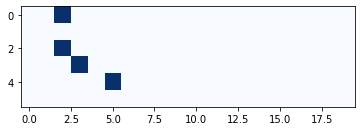

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
plt.imshow(lab, cmap=plt.cm.Blues, interpolation='nearest')
plt.show()

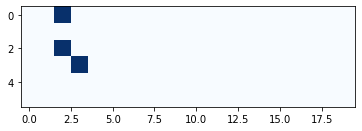

In [ ]:
plt.imshow(ans, cmap=plt.cm.Blues, interpolation='nearest')
plt.show()

In [ ]:
%matplotlib nbagg

import matplotlib.pyplot as plt 
import matplotlib.animation as animation

fig = plt.figure()
ims = []

training_generator, validation_generator = partition_data(0)
input_data = validation_generator[0]
images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2)))
labels = torch.Tensor(input_data[1])
outputs = net(images)
_, predicted = torch.max(outputs.data, 2)
gt = np.argmax(labels, 2)

for i in range(128):
  ans = tab2bin(predicted[i])
  lab = tab2bin(gt[i])
  im = plt.imshow(lab, cmap=plt.cm.Blues, interpolation='nearest', animated=True)
  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt 

ims = []
for i, (images, labels) in enumerate(validation_generator):
  input_data = validation_generator[i]
  images = torch.Tensor(np.transpose(input_data[0], (0,3,1,2)))
  labels = torch.Tensor(input_data[1])
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 2)
  gt = np.argmax(labels, 2)
  ans = tab2bin(predicted[0])
  lab = tab2bin(gt[0])
  im = plt.imshow(lab, cmap=plt.cm.Blues, interpolation='nearest')
  ims.append(im)

ani = animation.ArtistAnimation(ims)
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored